<a href="https://colab.research.google.com/github/smraniaki/BitTensor/blob/main/Model_pruning_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Purpose**
This technical challenge is for candidates to demonstrate their problem solving and
learning abilities. All tasks in this challenge are based on real-life examples of what you
could work on at Bittensor. There’s no right or wrong way to do this challenge, so don’t
stress out too much about it. The purpose is to facilitate a conversation about coding
best practices in machine learning applications. We want to see how you think and what
your opinions are.

# **Rules**
1. Consider using colab for access to free GPUs/TPUs.
2. You may use frameworks or libraries as you see fit. If you borrow code please
include proper attribution and have a clear separation between the code you
borrowed and the code you wrote yourself.
3. You should keep your code simple and focus on readability of your code.
Include any instructions for running and reading your code in a README file. We
value thoughtfully written clean, and communicative code so other
contributors can easily understand and build on top of it.
4. You may skip any parts of the challenge if you get stuck or don’t have relevant
experience. However, we encourage you to learn and demonstrate newly
acquired skills.
5. You should check your solution into GitHub or Colab and provide basic
instructions on how to reproduce your results.
6. You are free to spend as little or as much time as you want on this challenge.
7. You are expected to learn something new after you complete the challenge :)

# Dependency Installations

In [2]:
!mkdir images
!mkdir models

In [3]:
#! pip uninstall -y tensorflow
#! pip uninstall -y tf-nightly
! pip install -U tf-nightly-gpu
! pip install tensorflow-model-optimization

import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tempfile
import tensorboard


     |████████████████████████████████| 497.7 MB 26 kB/s 
     |████████████████████████████████| 1.5 MB 48.8 MB/s 
     |████████████████████████████████| 5.8 MB 39.4 MB/s 
     |████████████████████████████████| 15.7 MB 55.7 MB/s 
     |████████████████████████████████| 438 kB 49.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 234 kB 5.0 MB/s 


In [6]:
#tf.executing_eagerly()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

In [16]:
import tensorflow as tf
import timeit
import zipfile

from IPython.core.pylabtools import figsize
from numpy import linalg as LA
from tensorflow.keras.models import load_model
from tensorflow_model_optimization.sparsity import keras as sparsity

#tf.enable_eager_execution()
plt.style.use('fivethirtyeight')
sns.set_context('notebook')
pd.set_option('display.max_rows', 30)
np.random.seed(1337)
%config InlineBackend.figure_format = 'retina'
%load_ext tensorboard

# Dataset

We'll set up a function for loading both MNIST and FMNIST

In [17]:
def load_dataset(dataset='mnist'):
    """
    Loads and preprocesses the data for this task.
    Args:
      dataset: the name of the dataset to be used for this classification task.
        (mnist | fmnist)
    Returns:
      x_train: Features for training data 
      x_test: Features for test data
      y_train: Labels for training data
      y_test: Labels for test data
      num_classes: Number of classes for the dataset
    """
    # input image dimensions (equal for both MNIST and FMNIST)
    img_rows, img_cols = 28, 28
    
    if dataset=='mnist':
        # Number of classes in the data
        num_classes = 10
        
        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    elif dataset=='fmnist':
        # Number of classes in the data
        num_classes = 10
        
        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        
    else:
        print('dataset name does not match available options \n( mnist | keras )')

    x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
    input_shape = (img_rows*img_cols*1,)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, x_test, y_train, y_test, num_classes, input_shape

# We will load separate tensors for the MNIST and FMNIST data. 

mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test, num_classes, input_shape = load_dataset(dataset='mnist')

fmnist_x_train, fmnist_x_test, fmnist_y_train, fmnist_y_test, num_classes, input_shape = load_dataset(dataset='fmnist')


11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples
4422102/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples


## Training a keras model without pruning

We will construct a $ReLU$-activated neural network with four hidden layers. These layers will be dense, fully-connected layers with sizes $1000$, $1000$, $500$, & $200$.We'll also have have a fifth layer for the output logits, which we will have 10 (**Note:** Since these connect directly to the output layer, these will be spared from any and all pruning).

For the sake of simplicity, we will also omit Dropout layers, Convolutional layers, Batch Normalization Layers, and Avg Pooling Layers.

In [18]:
l = tf.keras.layers

def build_model_arch(input_shape, num_classes, sparsity=0.0):
    """
    Builds the model architecture
    Args:
      input_shape: The tuple describing the input shape
      num_classes: how many classes the data labels belong to
      sparsity: For compressing already sparse models, how much sparsity was used
    Returns:
      model: an un-compiled TF.Keras model with 4 hidden
        dense layers with shapes [1000, 1000, 500, 200]      
    """

    model = tf.keras.Sequential()

    model.add(l.Dense(int(1000-(1000*sparsity)), activation='relu',
                      input_shape=input_shape)),
    model.add(l.Dense(int(1000-(1000*sparsity)), activation='relu'))
    model.add(l.Dense(int(500-(500*sparsity)), activation='relu'))
    model.add(l.Dense(int(200-(200*sparsity)), activation='relu'))
    model.add(l.Dense(num_classes, activation='softmax'))

    return model


# The architectures are the same, but we are initializing 2 different sequential
# models. One is for MNIST, and one is for FMNIST

mnist_model_base = build_model_arch(input_shape, num_classes)
fmnist_model_base = build_model_arch(input_shape, num_classes)



Load [TensorBoard](https://www.tensorflow.org/tensorboard) to monitor the training process

In [19]:
logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)

Writing training logs to /tmp/tmpv43a_eny


## Training the model

In [20]:
def make_nosparse_model(model, x_train, y_train, batch_size, 
                         epochs, x_test, y_test):
    """
    Training our original model, pre-pruning
    Args:
      model: Uncompiled Keras model
      x_train: Features for training data 
      y_train: Labels for training data
      batch_size: Batch size for training
      epochs: Number of epochs for training
      x_test: Features for test data
      y_test: Labels for test data
    Returns:
      model: compiled model
      score: List of both final test loss and final test accuracy
    """
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]

    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model, score

batch_size = 128
epochs = 10

mnist_model, mnist_score = make_nosparse_model(mnist_model_base,
                                               mnist_x_train,
                                               mnist_y_train,
                                               batch_size,
                                               epochs,
                                               mnist_x_test,
                                               mnist_y_test)
print(mnist_model.summary())

fmnist_model, fmnist_score = make_nosparse_model(fmnist_model_base,
                                                 fmnist_x_train,
                                                 fmnist_y_train,
                                                 batch_size,
                                                 epochs,
                                                 fmnist_x_test,
                                                 fmnist_y_test)

print(fmnist_model.summary())

Epoch 1/10
469/469 [==============================] - 5s 6ms/step - loss: 0.2013 - accuracy: 0.9392 - val_loss: 0.1068 - val_accuracy: 0.9672
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0853 - accuracy: 0.9737 - val_loss: 0.0948 - val_accuracy: 0.9696
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.1146 - val_accuracy: 0.9704
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0463 - accuracy: 0.9854 - val_loss: 0.0846 - val_accuracy: 0.9743
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0393 - accuracy: 0.9878 - val_loss: 0.0780 - val_accuracy: 0.9782
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0294 - accuracy: 0.9911 - val_loss: 0.1012 - val_accuracy: 0.9750
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9916 - val_loss: 0.0703 - val_accuracy: 0.9815
Epoch 

In [22]:
%tensorboard --logdir={logdir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 292, in _run_serve_subcommand
    server = sel

# Pruning

Now that the model is trained, we are going to prune away (set to zero) weigths of the trained model. Two pruning methods will be used for this:

- **Weight pruning:** set individual weights in the weight matrix to zero. This corresponds to deleting connections as in the figure above.
    - Here, to achieve sparsity of $k%$ we rank the individual weights in weight matrix $W$ according to their magnitude (absolute value) $|w_{i,j}|$, and then set to zero the smallest $k%$.
- **Unit/Neuron pruning:** set entire columns to zero in the weight matrix to zero, in effect deleting the corresponding output neuron.
    - Here to achieve sparsity of $k%$ we rank the columns of a weight matrix according to their L2-norm $|w| = \sqrt{\sum_{i=1}^{N}(x_i)^2}$ and delete the smallest $k%$.



The $k\%$ of weights using weight and unit pruning for $k$ in [$0, 25, 50, 60, 70, 80, 90, 95, 97, 99$]. Neither of these pruning methods will prune the weights leading to the softmax layer.

## Pruning the layers



In [23]:
def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    """
    Takes in matrices of kernel and bias weights (for a dense
      layer) and returns the unit-pruned versions of each
    Args:
      k_weights: 2D matrix of the 
      b_weights: 1D matrix of the biases of a dense layer
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights: sparse matrix with same shape as the original
        kernel weight matrix
      bias_weights: sparse array with same shape as the original
        bias array
    """
    # Copy the kernel weights and get ranked indeces of the abs
    kernel_weights = np.copy(k_weights)
    ind = np.unravel_index(
        np.argsort(
            np.abs(kernel_weights),
            axis=None),
        kernel_weights.shape)
        
    # Number of indexes to set to 0
    cutoff = int(len(ind[0])*k_sparsity)
    # The indexes in the 2D kernel weight matrix to set to 0
    sparse_cutoff_inds = (ind[0][0:cutoff], ind[1][0:cutoff])
    kernel_weights[sparse_cutoff_inds] = 0.
        
    # Copy the bias weights and get ranked indeces of the abs
    bias_weights = np.copy(b_weights)
    ind = np.unravel_index(
        np.argsort(
            np.abs(bias_weights), 
            axis=None), 
        bias_weights.shape)
        
    # Number of indexes to set to 0
    cutoff = int(len(ind[0])*k_sparsity)
    # The indexes in the 1D bias weight matrix to set to 0
    sparse_cutoff_inds = (ind[0][0:cutoff])
    bias_weights[sparse_cutoff_inds] = 0.
    
    return kernel_weights, bias_weights
    

In [24]:
def unit_prune_dense_layer(k_weights, b_weights, k_sparsity):
    """
    Takes in matrices of kernel and bias weights (for a dense
      layer) and returns the unit-pruned versions of each
    Args:
      k_weights: 2D matrix of the 
      b_weights: 1D matrix of the biases of a dense layer
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights: sparse matrix with same shape as the original
        kernel weight matrix
      bias_weights: sparse array with same shape as the original
        bias array
    """

    # Copy the kernel weights and get ranked indeces of the
    # column-wise L2 Norms
    kernel_weights = np.copy(k_weights)
    ind = np.argsort(LA.norm(kernel_weights, axis=0))
        
    # Number of indexes to set to 0
    cutoff = int(len(ind)*k_sparsity)
    # The indexes in the 2D kernel weight matrix to set to 0
    sparse_cutoff_inds = ind[0:cutoff]
    kernel_weights[:,sparse_cutoff_inds] = 0.
        
    # Copy the bias weights and get ranked indeces of the abs
    bias_weights = np.copy(b_weights)
    # The indexes in the 1D bias weight matrix to set to 0
    # Equal to the indexes of the columns that were removed in this case
    #sparse_cutoff_inds
    bias_weights[sparse_cutoff_inds] = 0.
    
    return kernel_weights, bias_weights

## Pruning across an entire model

In [25]:
def sparsify_model(model, x_test, y_test, k_sparsity, pruning='weight'):
    """
    Takes in a model made of dense layers and prunes the weights
    Args:
      model: Keras model
      k_sparsity: target sparsity of the model
    Returns:
      sparse_model: sparsified copy of the previous model
    """
    # Copying a temporary sparse model from our original
    sparse_model = tf.keras.models.clone_model(model)
    sparse_model.set_weights(model.get_weights())
    
    # Getting a list of the names of each component (w + b) of each layer
    names = [weight.name for layer in sparse_model.layers for weight in layer.weights]
    # Getting the list of the weights for each component (w + b) of each layer
    weights = sparse_model.get_weights()
    
    # Initializing list that will contain the new sparse weights
    newWeightList = []

    # Iterate over all but the final 2 layers (the softmax)
    for i in range(0, len(weights)-2, 2):
        
        if pruning=='weight':
            kernel_weights, bias_weights = weight_prune_dense_layer(weights[i],
                                                                    weights[i+1],
                                                                    k_sparsity)
        elif pruning=='unit':
            kernel_weights, bias_weights = unit_prune_dense_layer(weights[i],
                                                                  weights[i+1],
                                                                  k_sparsity)
        else:
            print('does not match available pruning methods ( weight | unit )')
        
        # Append the new weight list with our sparsified kernel weights
        newWeightList.append(kernel_weights)
        
        # Append the new weight list with our sparsified bias weights
        newWeightList.append(bias_weights)

    # Adding the unchanged weights of the final 2 layers
    for i in range(len(weights)-2, len(weights)):
        unmodified_weight = np.copy(weights[i])
        newWeightList.append(unmodified_weight)

    # Setting the weights of our model to the new ones
    sparse_model.set_weights(newWeightList)
    
    # Re-compiling the Keras model (necessary for using `evaluate()`)
    sparse_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    
    # Printing the the associated loss & Accuracy for the k% sparsity
    score = sparse_model.evaluate(x_test, y_test, verbose=0)
    print('k% weight sparsity: ', k_sparsity,
          '\tTest loss: {:07.5f}'.format(score[0]),
          '\tTest accuracy: {:05.2f} %%'.format(score[1]*100.))
    
    return sparse_model, score
 

## Weight-and-unit pruning across all $k\%$ sparsities

In [26]:
#@title Loop over each k% sparsity in the list

# list of sparsities
k_sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

# The empty lists where we will store our training results
mnist_model_loss_weight = []
mnist_model_accs_weight = []
mnist_model_loss_unit = []
mnist_model_accs_unit = []
fmnist_model_loss_weight = []
fmnist_model_accs_weight = []
fmnist_model_loss_unit = []
fmnist_model_accs_unit = []

dataset = 'mnist'
pruning = 'weight'
print('\n MNIST Weight-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(mnist_model, x_test=mnist_x_test,
                                         y_test=mnist_y_test,
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    mnist_model_loss_weight.append(score[0])
    mnist_model_accs_weight.append(score[1])
    
    # Save entire model to an H5 file
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model


pruning='unit'
print('\n MNIST Unit-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(mnist_model, x_test=mnist_x_test,
                                         y_test=mnist_y_test, 
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    mnist_model_loss_unit.append(score[0])
    mnist_model_accs_unit.append(score[1])
    
    # Save entire model to an H5 file
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model

dataset = 'fmnist'
pruning = 'weight'
print('\n FMNIST Weight-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(fmnist_model, x_test=fmnist_x_test,
                                         y_test=fmnist_y_test,
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    fmnist_model_loss_weight.append(score[0])
    fmnist_model_accs_weight.append(score[1])
    
    # Save entire model to an H5 file
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model


pruning='unit'
print('\n FMNIST Unit-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(fmnist_model, x_test=fmnist_x_test,
                                         y_test=fmnist_y_test, 
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    fmnist_model_loss_unit.append(score[0])
    fmnist_model_accs_unit.append(score[1])
    
    # Save entire model to an H5 file
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model




 MNIST Weight-pruning

k% weight sparsity:  0.0 	Test loss: 0.07516 	Test accuracy: 98.29 %%
k% weight sparsity:  0.25 	Test loss: 0.07334 	Test accuracy: 98.30 %%
k% weight sparsity:  0.5 	Test loss: 0.06814 	Test accuracy: 98.29 %%
k% weight sparsity:  0.6 	Test loss: 0.06469 	Test accuracy: 98.22 %%
k% weight sparsity:  0.7 	Test loss: 0.07172 	Test accuracy: 98.08 %%
k% weight sparsity:  0.8 	Test loss: 0.18134 	Test accuracy: 97.71 %%
k% weight sparsity:  0.9 	Test loss: 1.20592 	Test accuracy: 91.77 %%
k% weight sparsity:  0.95 	Test loss: 2.08961 	Test accuracy: 32.77 %%
k% weight sparsity:  0.97 	Test loss: 2.25079 	Test accuracy: 13.08 %%
k% weight sparsity:  0.99 	Test loss: 2.30206 	Test accuracy: 09.74 %%

 MNIST Unit-pruning

k% weight sparsity:  0.0 	Test loss: 0.07516 	Test accuracy: 98.29 %%
k% weight sparsity:  0.25 	Test loss: 0.06839 	Test accuracy: 98.29 %%
k% weight sparsity:  0.5 	Test loss: 0.09120 	Test accuracy: 98.08 %%
k% weight sparsity:  0.6 	Test loss: 0.

### Organizing these results into one Pandas DataFrame

In [27]:
# Convert the lists to numpy arrays
k_sparsities = np.asarray(k_sparsities)
mnist_model_loss_weight = np.asarray(mnist_model_loss_weight)
mnist_model_accs_weight = np.asarray(mnist_model_accs_weight)
mnist_model_loss_unit = np.asarray(mnist_model_loss_unit)
mnist_model_accs_unit = np.asarray(mnist_model_accs_unit)
fmnist_model_loss_weight = np.asarray(fmnist_model_loss_weight)
fmnist_model_accs_weight = np.asarray(fmnist_model_accs_weight)
fmnist_model_loss_unit = np.asarray(fmnist_model_loss_unit)
fmnist_model_accs_unit = np.asarray(fmnist_model_accs_unit)

# Stack the arrays so they can be used in the DataFrame
sparsity_data = np.stack([k_sparsities,
                          mnist_model_loss_weight,
                          mnist_model_accs_weight,
                          mnist_model_loss_unit,
                          mnist_model_accs_unit,
                          fmnist_model_loss_weight,
                          fmnist_model_accs_weight,
                          fmnist_model_loss_unit,
                          fmnist_model_accs_unit])

# Defining the Pandas DataFrame
sparsity_summary = pd.DataFrame(data=sparsity_data.T,    # values
                                columns=['k_sparsity',   # Column names
                                         'mnist_loss_weight',
                                         'mnist_acc_weight',
                                         'mnist_loss_unit',
                                         'mnist_acc_unit',
                                         'fmnist_loss_weight',
                                         'fmnist_acc_weight',
                                         'fmnist_loss_unit',
                                         'fmnist_acc_unit'])
sparsity_summary.to_csv('sparsity_summary.csv')
sparsity_summary

,k_sparsity,mnist_loss_weight,mnist_acc_weight,mnist_loss_unit,mnist_acc_unit,fmnist_loss_weight,fmnist_acc_weight,fmnist_loss_unit,fmnist_acc_unit
0,0.00,0.075162,0.9829,0.075162,0.9829,0.338851,0.8863,0.338851,0.8863
1,0.25,0.073344,0.9830,0.068391,0.9829,0.341286,0.8847,0.334703,0.8858
2,0.50,0.068144,0.9829,0.091199,0.9808,0.335488,0.8820,0.378693,0.8784
3,0.60,0.064686,0.9822,0.300954,0.9731,0.331845,0.8843,0.524692,0.8723
4,0.70,0.071723,0.9808,0.805348,0.9543,0.350964,0.8780,0.948614,0.7760
5,0.80,0.181342,0.9771,1.707605,0.8818,0.466827,0.8513,1.501774,0.6358
6,0.90,1.205917,0.9177,2.217106,0.2665,1.049658,0.6876,2.129623,0.3074
7,0.95,2.089611,0.3277,2.296855,0.0976,1.783675,0.4310,2.297503,0.1095
8,0.97,2.250792,0.1308,2.303448,0.0974,2.135953,0.2576,2.308087,0.1025
9,0.99,2.302058,0.0974,2.304971,0.0974,2.297517,0.1319,2.306302,0.1000


## Plotting

### Visualizing Sparsity

In [28]:
def visualize_model_weights(sparse_model):
    """
    Visualize the weights of the layers of the sparse model.
    For weights with values of 0, they will be represented by the color white
    Args:
      sparse_model: a TF.Keras model
    """
    weights = sparse_model.get_weights()
    names = [weight.name for layer in sparse_model.layers for weight in layer.weights]
    
    my_cmap = matplotlib.cm.get_cmap('rainbow')
    my_cmap.set_under('w')
    
    # Iterate over all the weight matrices in the model and visualize them
    for i in range(len(weights)):
        weight_matrix = weights[i]
        layer_name = names[i]
        if weight_matrix.ndim == 1: # If Bias or softmax
            weight_matrix = np.resize(weight_matrix,
                                      (1,weight_matrix.size))
            plt.imshow(np.abs(weight_matrix),
                       interpolation='none',
                       aspect = "auto",
                       cmap=my_cmap,
                       vmin=1e-26); # lower bound is set close to but not at 0
            plt.colorbar()
            plt.title(layer_name)
            plt.show()
        else: # all other 2D matrices
            plt.imshow(np.abs(weight_matrix),
                       interpolation='none',
                       cmap=my_cmap,
                       vmin=1e-26);
            plt.colorbar()
            plt.title(layer_name)
            plt.show()
    


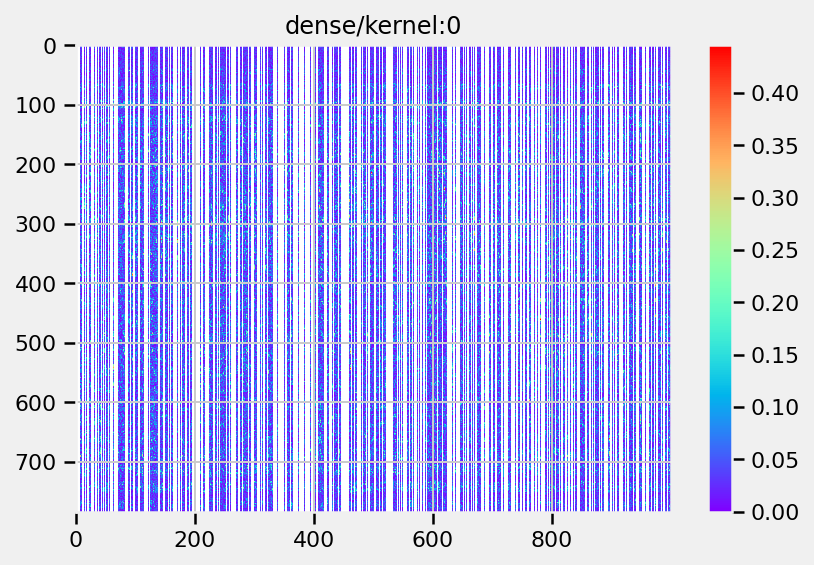

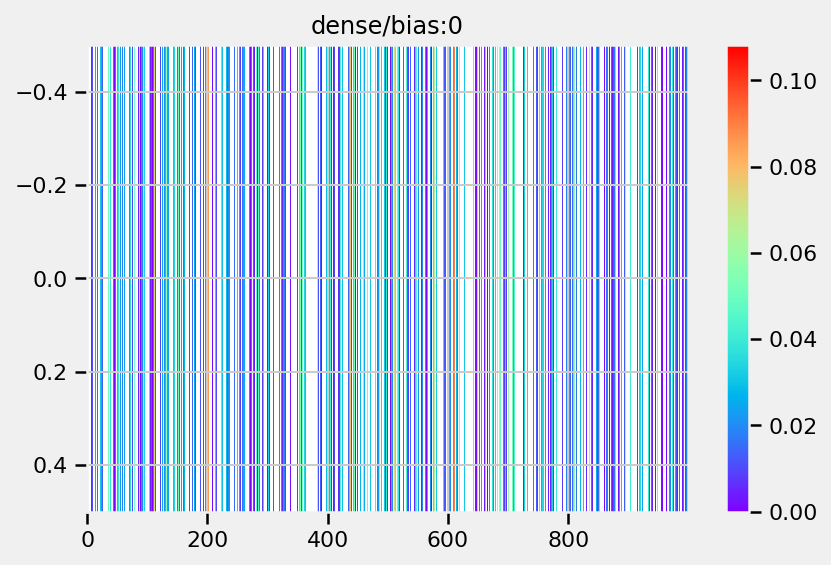

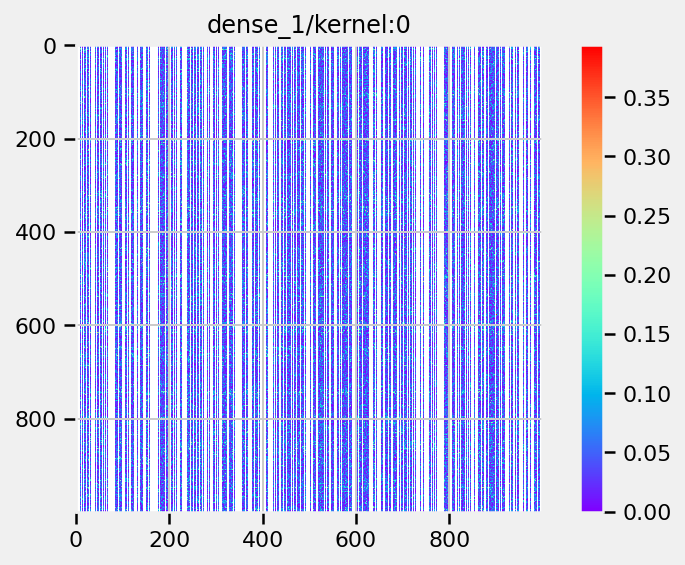

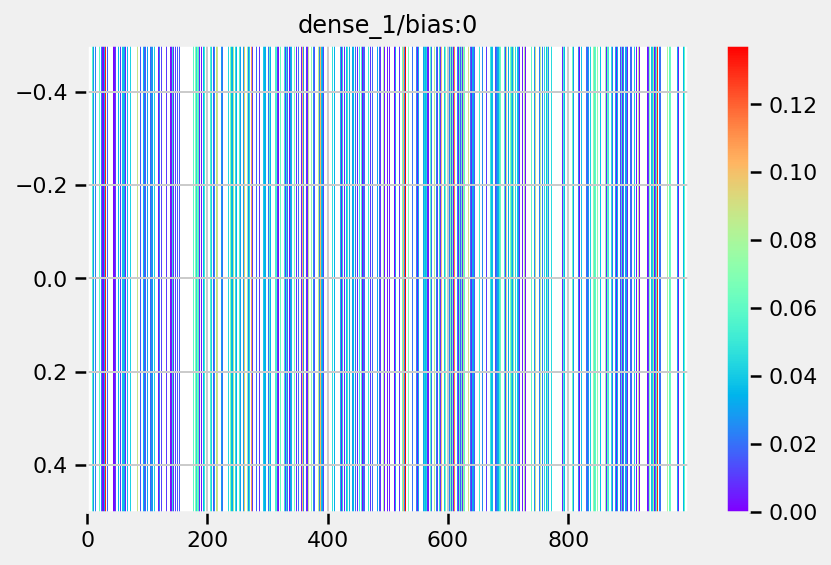

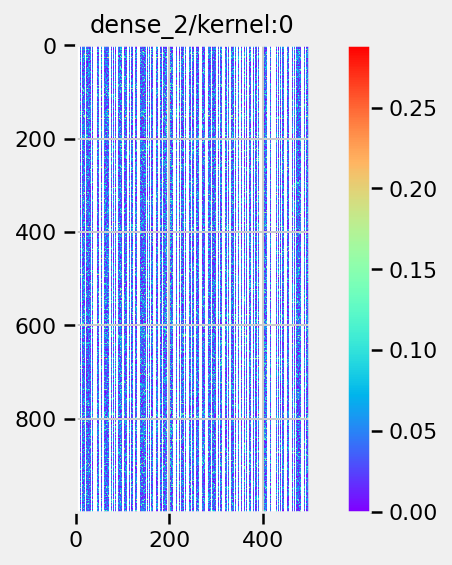

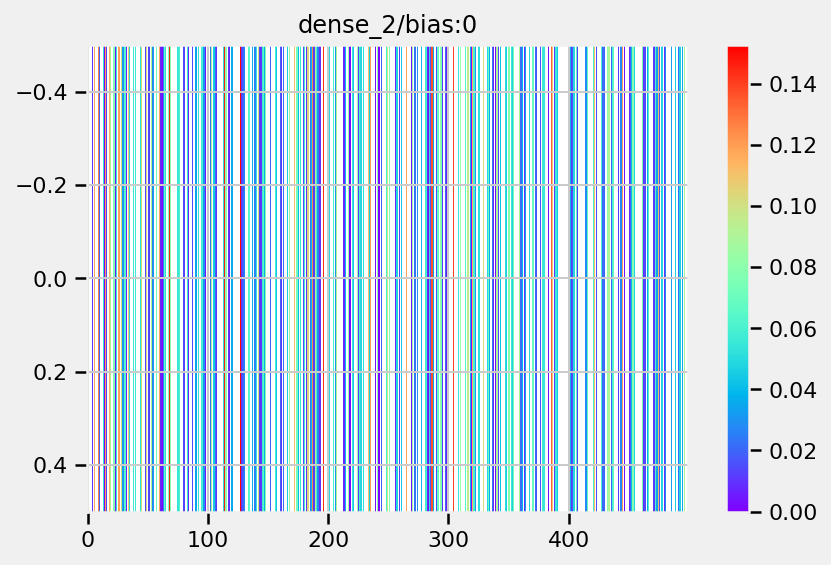

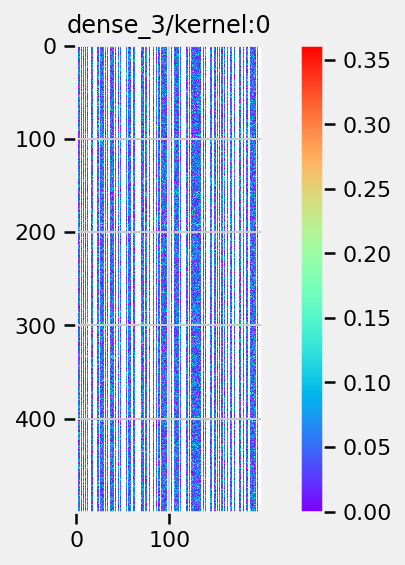

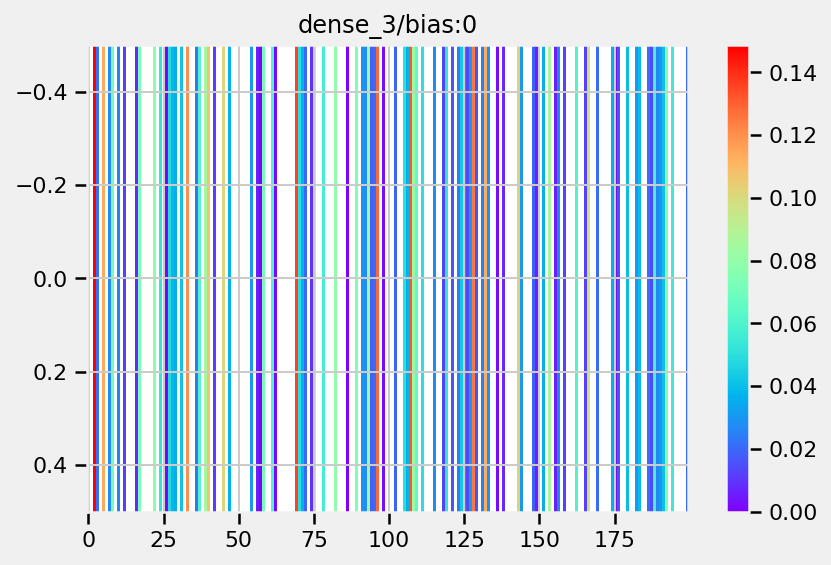

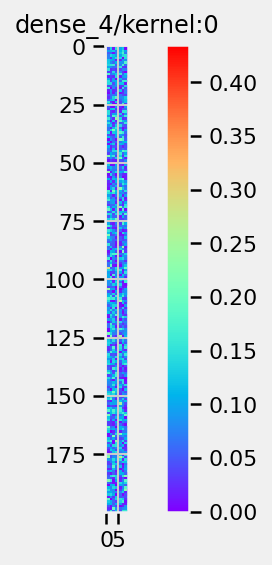

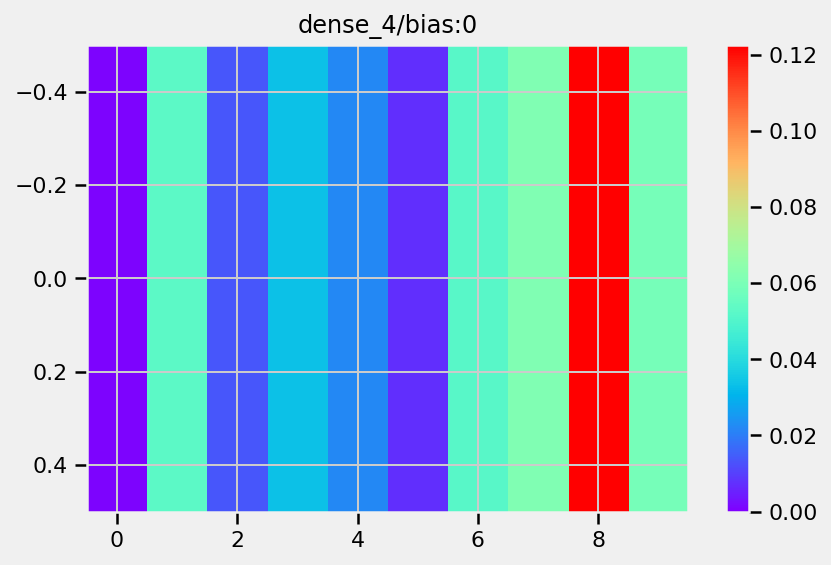

In [29]:
#@title Dense Layer visualization { run: "auto" }

#@markdown In Google Colab, this file becomes interactive, and you can select the sparse model you want to retrieve.
#@markdown 
#@markdown All weights with values of `0.0` will be color-coded weight. 1D Bias layers will be auto-scaled to the dimensions of the 2D plots.
#@markdown 
#@markdown Which dataset?
dataset = 'mnist' #@param ['mnist', 'fmnist']
#@markdown k sparsity
sparsity = "0.5" #@param ['0.0', '0.25', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.97', '0.99']
#@markdown Pruning method.
pruning = 'unit' #@param ['unit', 'weight']

sparse_model = load_model('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, sparsity, pruning))

visualize_model_weights(sparse_model)

### Visualizing sparse model performance on MNIST and FMNIST

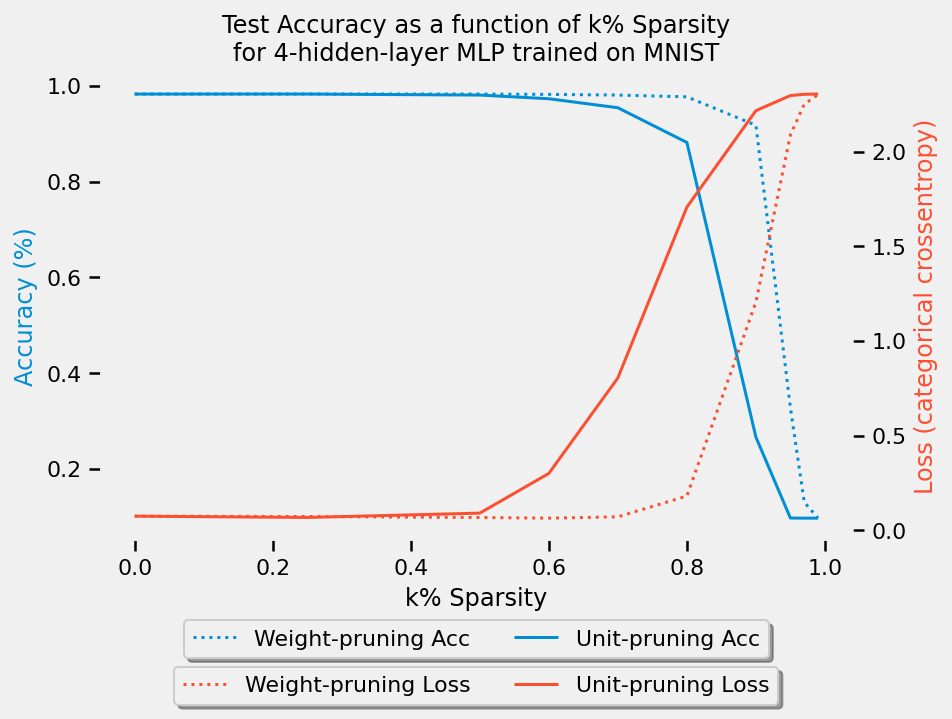

In [30]:
# Visualizing performance on MNIST
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor 4-hidden-layer MLP trained on MNIST')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_acc_weight'].values,
         '#008fd5', linestyle=':', label='Weight-pruning Acc')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_acc_unit'].values,
         '#008fd5', linestyle='-', label='Unit-pruning Acc')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_loss_weight'].values,
         '#fc4f30', linestyle=':', label='Weight-pruning Loss')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_loss_unit'].values,
         '#fc4f30', linestyle='-', label='Unit-pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('images/MNIST_sparsity_comparisons.png')

The performance curves for unit and weight pruning differ on MNIST. 

Pruing weight matrices of dense matrices does not result in dramatic drops in accuracy or increases in loss until around $k=80$. Even then, the accuracy does not begin to noticeably decrease until $k=90$.

For unit-pruning, accuracy begins to fall earlier, around $k=70$ (with loss beginning to increase around $k=60$). Even then, both methods are able to effecively remove more than half of the network weights without any dramatic differences in test classification performance.

How does this work on FMNIST?

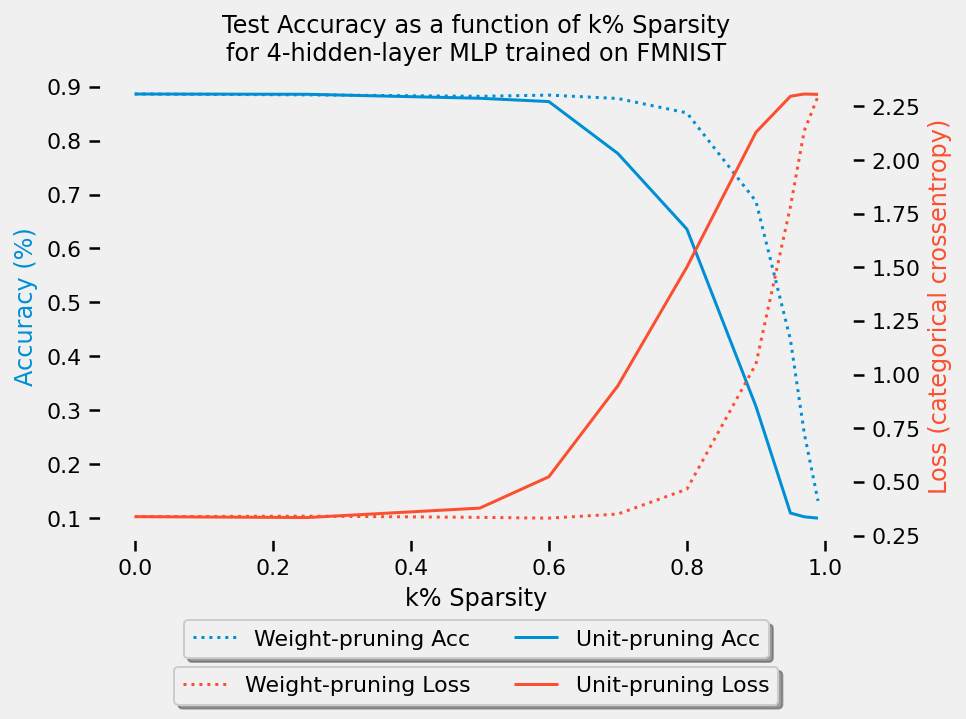

In [31]:
# Visualizing performance on KMNIST
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor 4-hidden-layer MLP trained on FMNIST')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_acc_weight'].values,
         '#008fd5', linestyle=':', label='Weight-pruning Acc')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_acc_unit'].values,
         '#008fd5', linestyle='-', label='Unit-pruning Acc')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_loss_weight'].values,
         '#fc4f30', linestyle=':', label='Weight-pruning Loss')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_loss_unit'].values,
         '#fc4f30', linestyle='-', label='Unit-pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('images/FMNIST_sparsity_comparisons.png')

Even on FMNIST, which had a lower initial accuracy and higher initial loss, the same pattern emerges

Again, pruing weight matrices of dense matrices does not result in dramatic drops in accuracy or increases in loss until around $k=80$. Even then, the accuracy does not begin to noticeably decrease until $k=90$.

For unit-pruning, the differences come much earlier for FMNIST than in MNIST. Accuracy begins to fall around $k=60$ (with loss beginning to increase around $k=60$).

#Step 7

**Why do you think that is/isn’t?**

The two methods use different strategies of finding the least useful weights. The weight-pruning finds the absolute values ($|w|$) of individual weights within the weight matrices. The unit-pruning finds L2 norms across entire columns of weight matrices. This difference is in part a difference between fine-grained and coarse-grained weight pruning.

Both the weight-pruning and unit-pruning are forms of [saliency mapping](https://en.wikipedia.org/wiki/Saliency_map). The pruning functions are going through the weight matrices and identifying the weights that would have minimal impact if they were multiplied with input data being fed into the layer. Given that some weights are orders of magnitude smaller than the largest ones, the impact of removing them is minimal. What is suprising is how much of the weight matrices are made up of these low-saliency weights.

**Do you have any hypotheses as to why we are able to delete so much of the network without hurting performance (this is an open research question)?**

This demonstration shows that neural network parameter counts of trained networks can be decreased by over $80\%$ without hurting perofrmance. Other researchers have demonstrated pruning techniques that can decrease parameter counts by over $90\%$. 

This bears some similarity to the ["optimal brain damage" hypothesis by Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-90b.pdf). In addition to being based on practical observations of differences in weight activations in neural networks, this bears similarity to ideas of how biological neural networks (like those in the neocortex) specialize. .

[[Frankle & Carbin, 2019]](https://arxiv.org/abs/1803.03635) proposed the "Lottery Ticket hypothesis". This hypthesis articulates that dense, randomly-initialized, feed-forward networks contain subnetworks ("winning tickets") that - when trained in isolation - reach test accuracy comparable to the original network in a similar number of iterations. It is named for the fact that these subnetworks, when initialized with random initialization, just happened to get initial weights that make training marticularly effective (i.e., they have won the "training lottery") For the task of MNIST, both weight-pruning and unit-pruning suggest that $2,388,710$ trainable parameters is supervluous compared to the truly optimal subnetwork that captures the concise classification function.

In finding ways of scaling the weights (or columns of weights), and removing the $k \%$ closest to $0$, we are trying to filter out all but the weights that make the input features maximally separable. [[Zhang et al., 2018]](https://arxiv.org/abs/1808.02229) compared the use of this kind of separation to Grassmannian Manifolds. Given that there is no universal formula to figuring out provably optimal subspace packings, the Grassmannian model of neural networks frames them as approximators of the solutions. Given that this is a less than optimal packing, some of the subspaces of the weights (e.g., those represented either as individual weights or vectors of weights) can easily be removed without impacting the performance of the classification. At some point, there are no more values to remove save for those satisfying the subspace packing needed for the maximum separability of the classes.

The latent variable model of neural network function would suggest that neural networks work by trying to learn the requisite latent variables ([David ha's blog post is a great example of this](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/)) needed to capture the epistemological essense of the given class. As David Ha's example shows, very high resolution images of MNIST digits can be produced from a generator with a vector containing just $32$ real numbers.

For finding minimum subnetwork (as framed by the "lottery-ticket hypothesis"), the optimal subspace packing (as framed by the ), it is also possible that there is more room for improvement beyond weight-pruning. Weight pruning looks at individual weight values in isolation. While the Unit pruning seems to suggest that looking at weights in combination does not produce better results, this is only one such filter for choosing weights to set to $0$. Uber AI tested out multiple masks for finding the "lottery-ticket" subnetworks.

![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/blog_header_2.png)
_Figure from Uber AI's ICML 2019 poster [Deconstructing Lottery Tickets: Zeros, Signs, and the Supermask](https://eng.uber.com/deconstructing-lottery-tickets/)_

It is also important to note that this pruning method only involves setting weight values below a certain threshold to $0$ and then testing immediately afterwards. The experiments shown in the code do not demonstrate successive rounds of successive weight pruning across multiple training rounds (like what [TF2.0's pruning API](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras) allows for)

# Reducing model runtime with Sparsity
We will also test how much our models can be compressed using this new sparsity, and if this will speed up execution.



## Compressing model _without_ [TF model optimization toolkit](https://www.tensorflow.org/model_optimization)

In [33]:
def compress_sparse_weigths(sparse_model_weight_list, unique_columns=None):
    """
    Given a list of weight matrices of the layers, compreses all sparse matrices
    save for the last two layers
    Args:
      sparse_model_weight_list: List of weight matrices for kernel and bias
        weights.
    Returns:
      compressed_weight_list: list of weight matrices similar to the input list
        of matrices, except the dimensions have been reduced by omitting columns
        populated exclusively by 0s.
    """
    compressed_weight_list = []
    
    for i in range(0,len(sparse_model_weight_list)-2,2):
        # If this is just after the input layer, the matrix with input
        # dimensions will be added on unchanged. Otherwise the matrix will only
        # retain the columns that are not entirely 0s
        
        if unique_columns==None:
            kernel_weights = sparse_model_weight_list[i]
        else:
            kernel_weights = sparse_model_weight_list[i][unique_columns,:]
        bias_weights = sparse_model_weight_list[i+1]
        
        # a tuple of two arrays: 0th is row indices, 1st is cols
        indices = np.nonzero(kernel_weights)
        columns_non_unique = indices[1]
        unique_columns = sorted(set(columns_non_unique))
        kernel_weights = kernel_weights[:,unique_columns]
        
        bias_weights = bias_weights[unique_columns]
        
        # Adding the new kernel and bias weights to the new list
        compressed_weight_list.append(kernel_weights)
        compressed_weight_list.append(bias_weights)
    
    # Adding the softmax and modifying the pre-softmax weight matrices
    compressed_weight_list.append(sparse_model_weight_list[-2][unique_columns,:])
    compressed_weight_list.append(sparse_model_weight_list[-1])
    
    return compressed_weight_list

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                39250     
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 10)                260       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
Total params: 43,445
Trainable params: 43,445
Non-trainable params: 0
_________________________________________________________________
None

VISUALIZING ORIGINAL SPARSE MODEL


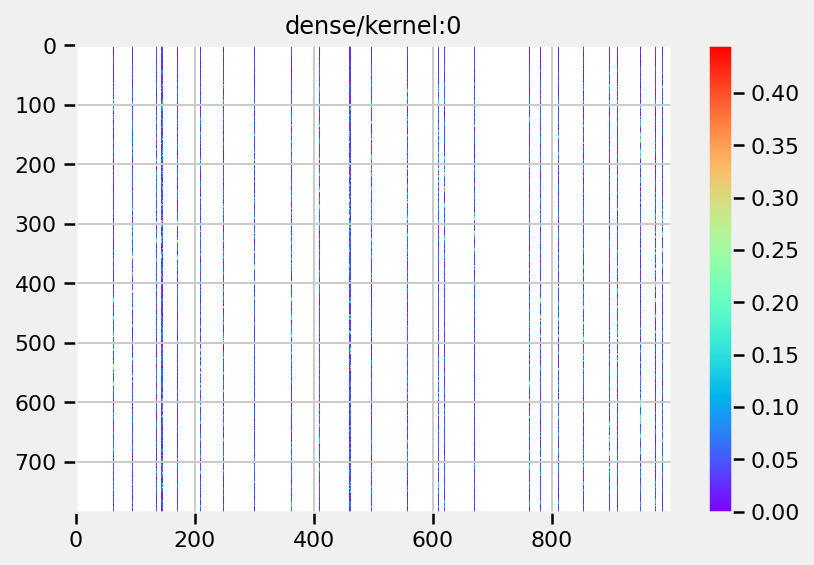

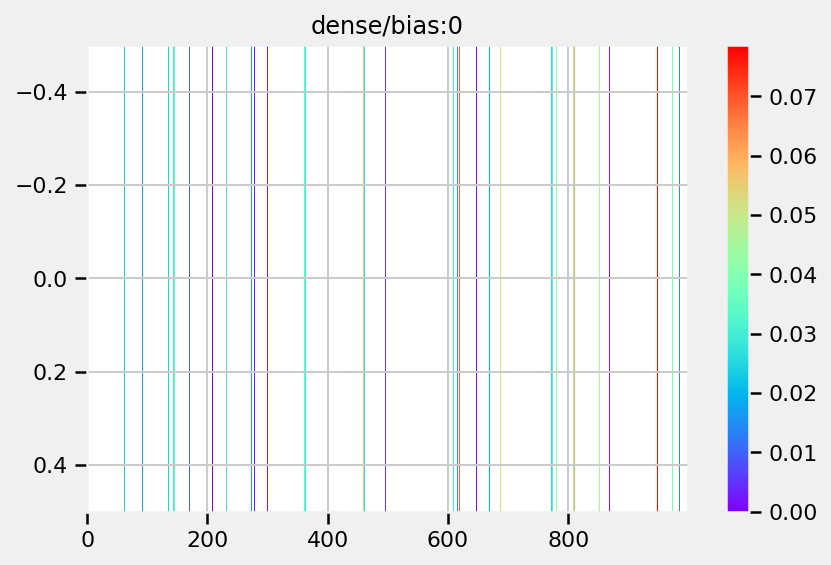

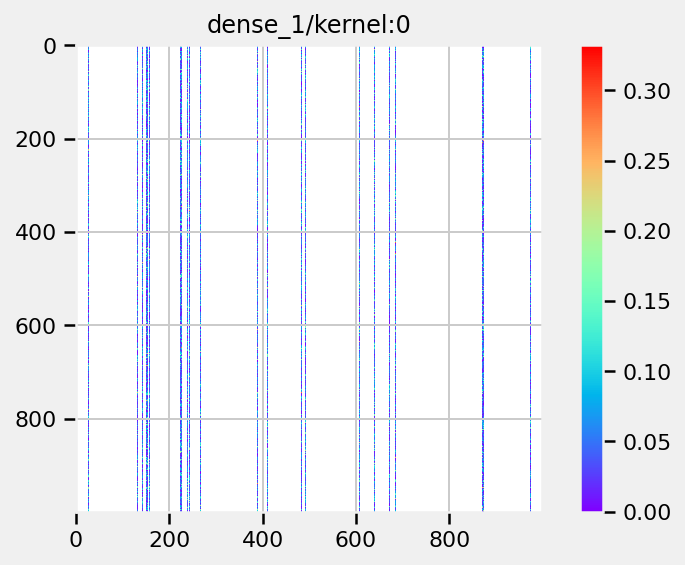

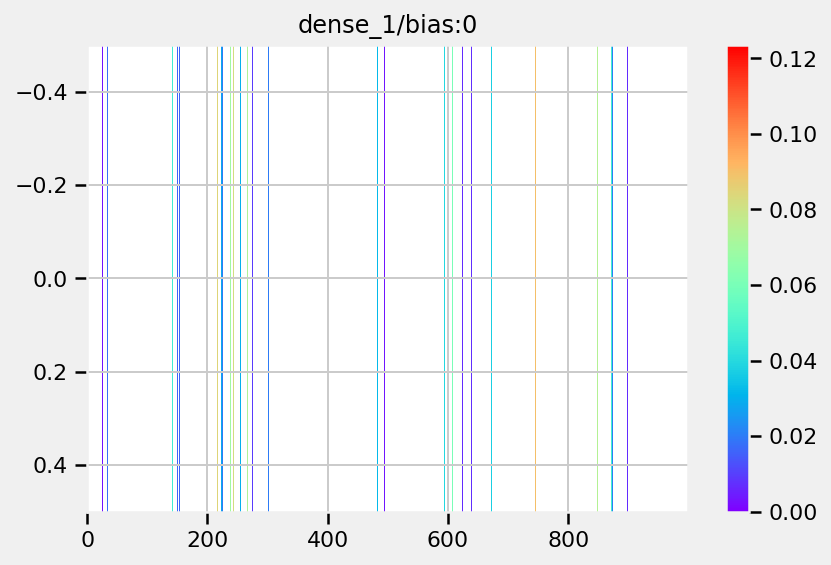

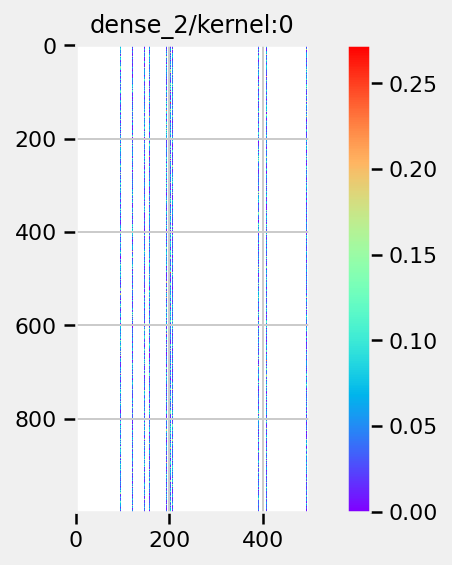

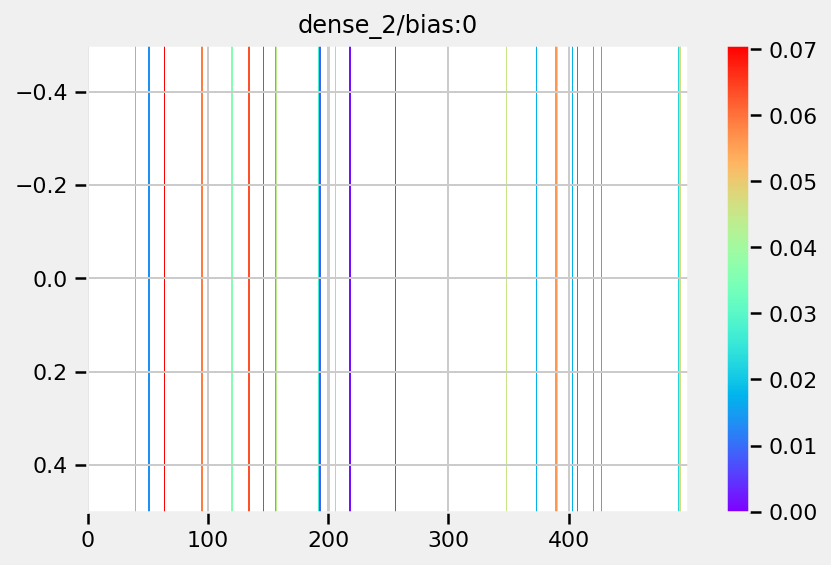

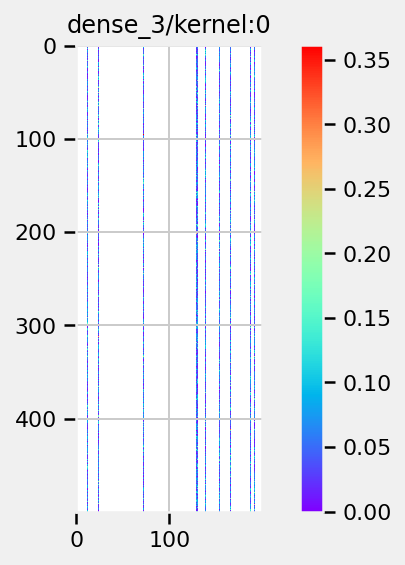

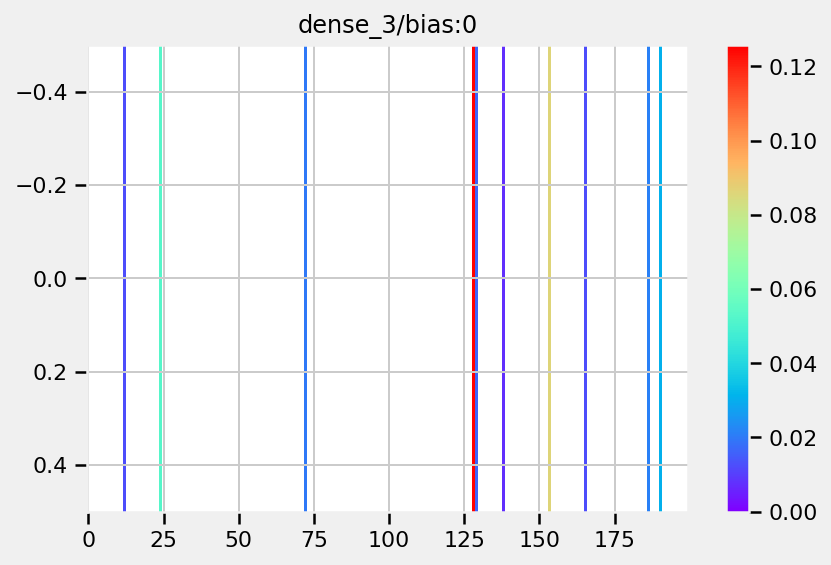

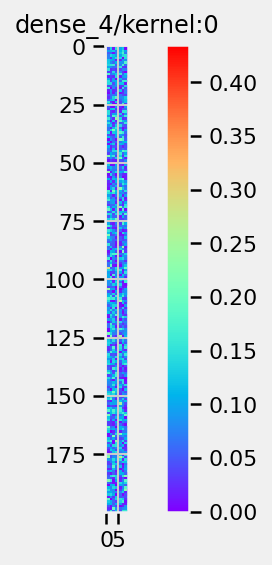

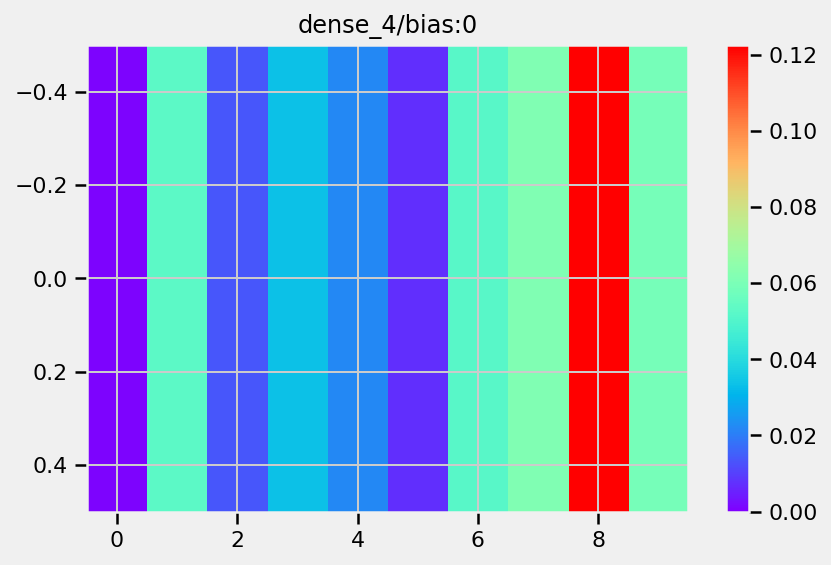


VISUALIZING COMPRESSED MODEL


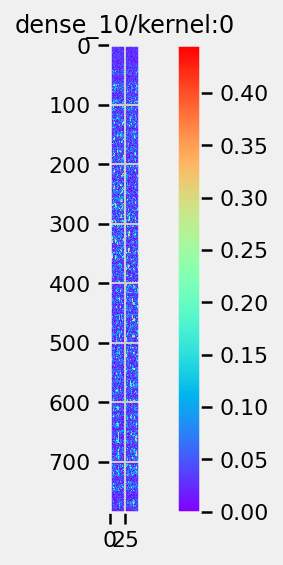

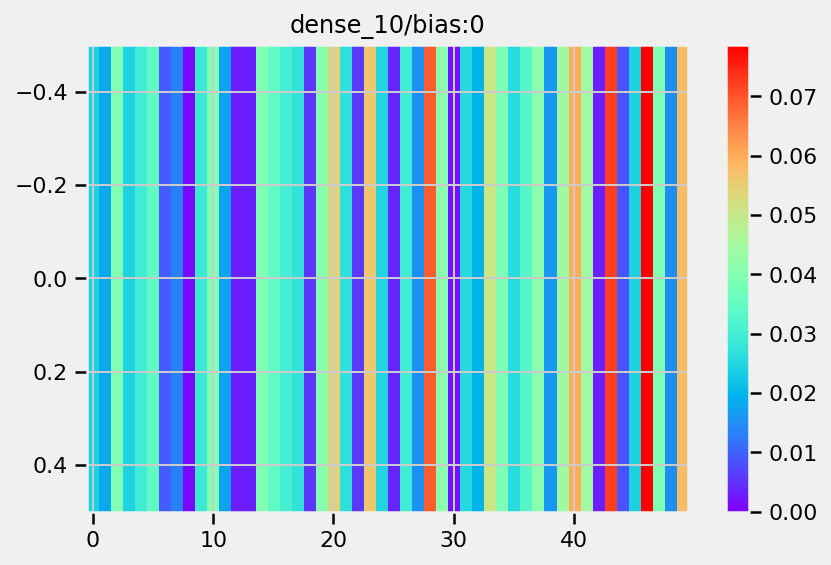

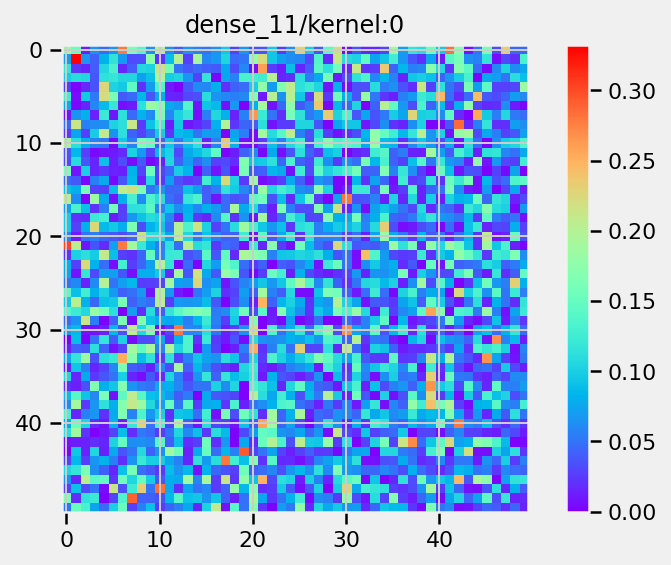

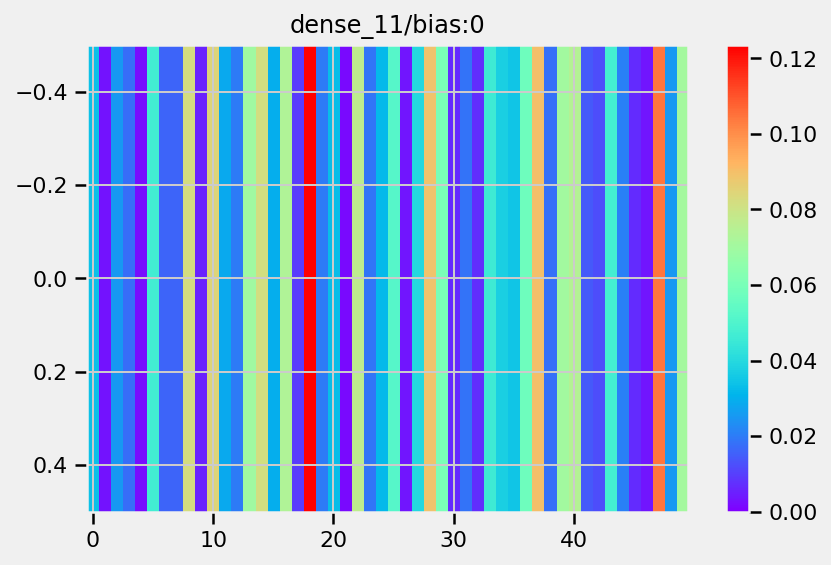

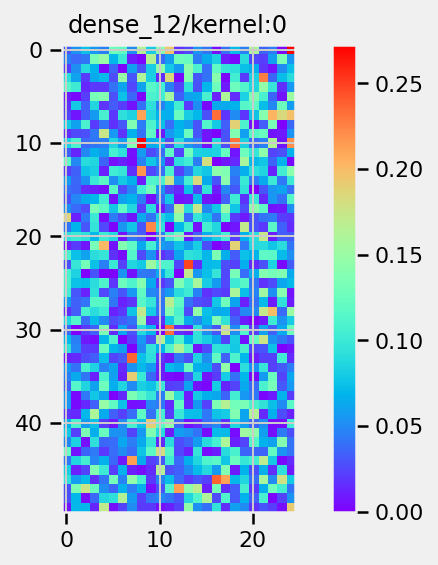

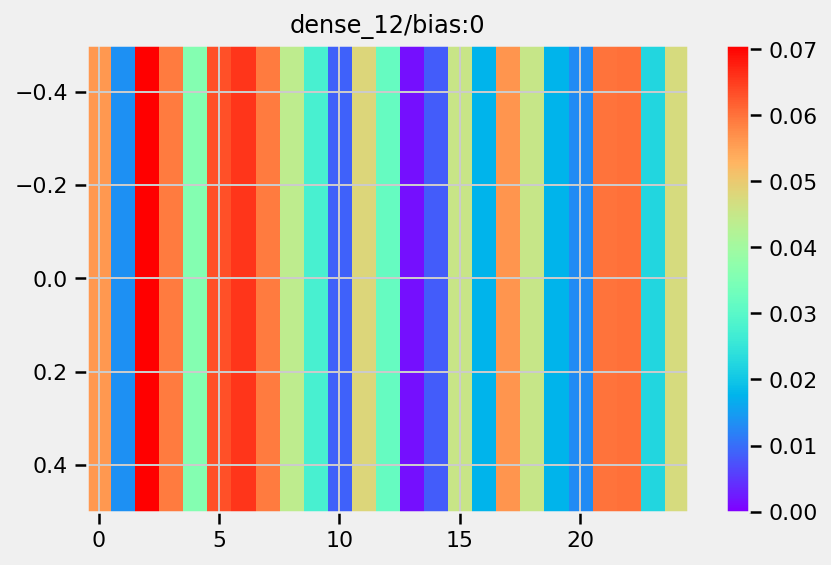

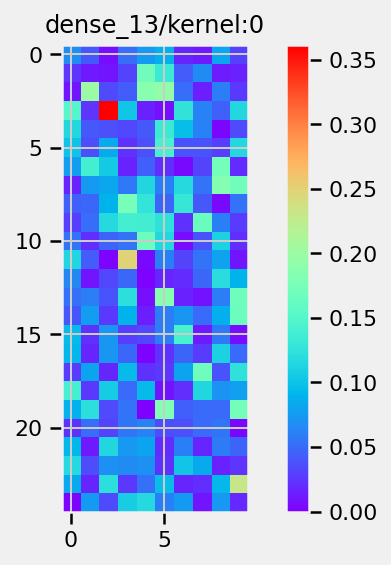

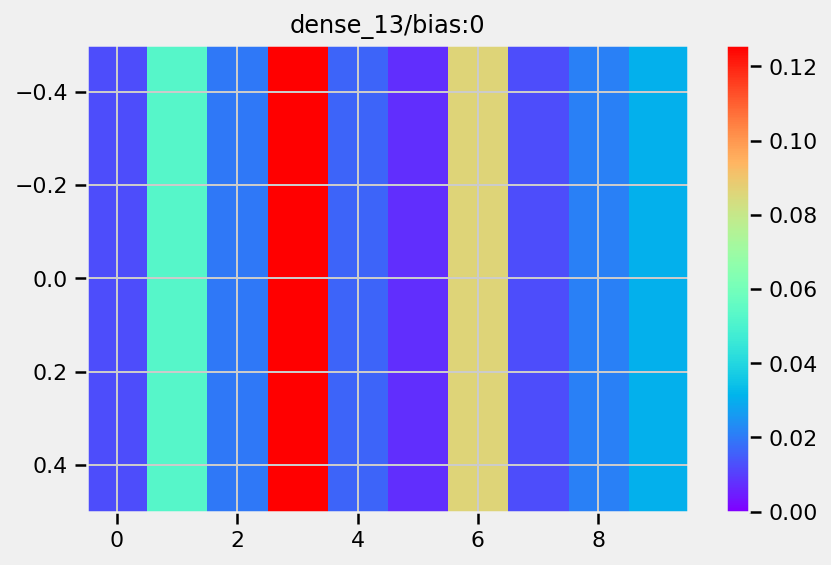

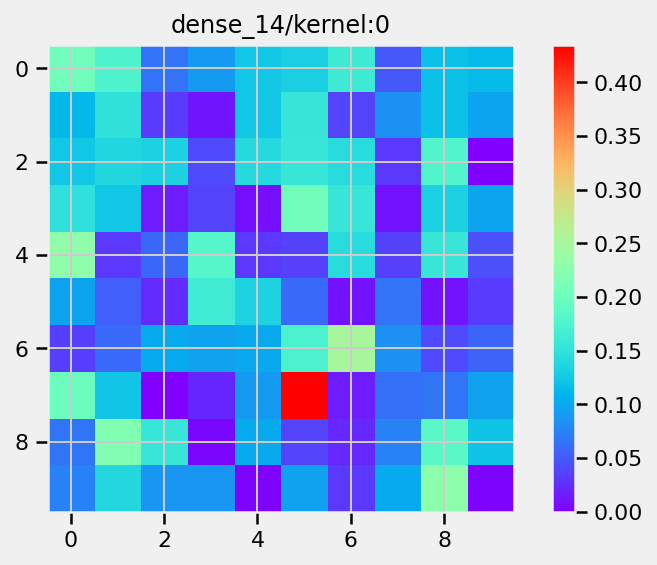

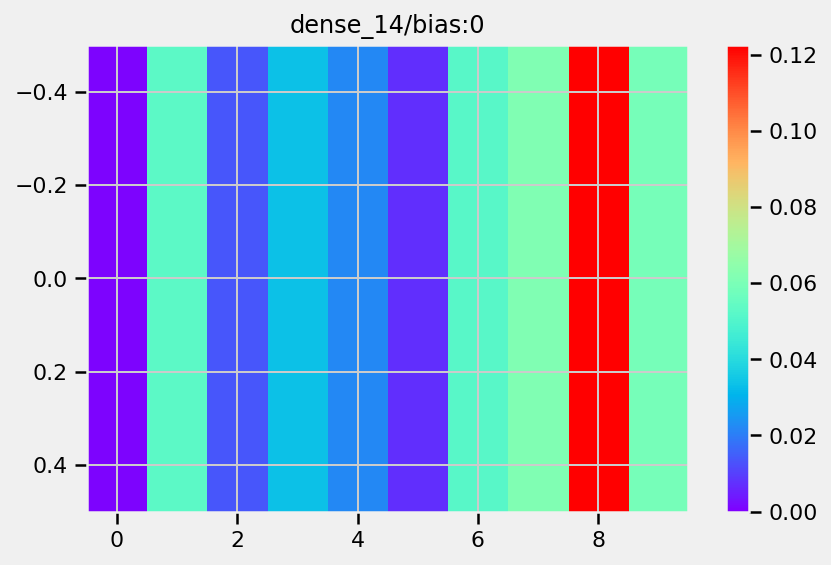

In [34]:
#@title Compressing sparse models (from saved files)

#@markdown Which dataset?
dataset = 'mnist' #@param ['mnist', 'fmnist']
#@markdown k sparsity
sparsity = "0.95" #@param ['0.0', '0.25', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.97', '0.99']
#@markdown We are only using sparse models that have undrgone **unit** pruning
pruning = 'unit'
sparse_model = load_model('models/sparse_{}-model_k-{}_unit-pruned.h5'.format(dataset, sparsity, pruning))

# List of weights from the loaded file
sparse_weight_list = sparse_model.get_weights()

# Creating a list of dense weights from the sparse weight list
compressed_weight_list = compress_sparse_weigths(sparse_weight_list)

# Getting a 4-layer neural network with layer dimensions that match those of
# the new dense weight matrices (e.g., at 50% sparsity, layer size of 1000 is 
# reduced to 500)
compressed_model = build_model_arch(input_shape, num_classes, sparsity=float(sparsity))
compressed_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                         optimizer='adam', metrics=['accuracy'])
compressed_model.set_weights(compressed_weight_list)

# Printing the model summaries and comparing the weights of the original sparse
# model and the dense model
print(compressed_model.summary())
print('\nVISUALIZING ORIGINAL SPARSE MODEL')
visualize_model_weights(sparse_model)
print('\nVISUALIZING COMPRESSED MODEL')
visualize_model_weights(compressed_model)

#### Execution time comparison

In [35]:
# Specifying the test data for the execution time tests
print('testing on {}'.format(dataset))
if dataset=='mnist':
    x_test = mnist_x_test
    y_test = mnist_y_test 
elif dataset=='fmnist':
    x_test = fmnist_x_test 
    y_test = fmnist_y_test
else:
    print('ERROR: Unrecognized dataset name')


testing on mnist


In [ ]:
%time
old_score = sparse_model.evaluate(x_test, y_test, verbose=0)

In [37]:
%time
new_score = compressed_model.evaluate(x_test, y_test, verbose=0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [38]:
# Just a confirmation that the accuracy is the same
print('k% weight sparsity (unit pruning): ', sparsity,
      '\nuncompressed',
      '\tTest loss: {:07.5f}'.format(old_score[0]),
      '\tTest accuracy: {:05.2f} %%'.format(old_score[1]*100),
      '\ncompressed',
      '\tTest loss: {:07.5f}'.format(new_score[0]),
      '\tTest accuracy: {:05.2f} %%'.format(new_score[1]*100))

k% weight sparsity (unit pruning):  0.95 
uncompressed 	Test loss: 2.29686 	Test accuracy: 09.76 %% 
compressed 	Test loss: 2.29686 	Test accuracy: 09.76 %%


**Not** only does our compressed model get similar loss and accuracy as the non-compressed, but it also achieves the same result in less time.

# References/Resources

- ["Pruning deep neural networks to make them fast and small"](https://jacobgil.github.io/deeplearning/pruning-deep-learning), _Jacob's Computer Vision and Machine Learning blog_
- Molchanov, Pavlo, et al. ["Pruning convolutional neural networks for resource efficient inference."](https://arxiv.org/abs/1611.06440) arXiv preprint arXiv:1611.06440 (2016).
- Li, Hao, et al. ["Pruning filters for efficient convnets."](https://arxiv.org/abs/1608.08710) arXiv preprint arXiv:1608.08710 (2016).
- Saliency map. _Wikipedia_. https://en.wikipedia.org/wiki/Saliency_map
- http://yann.lecun.com/exdb/publis/pdf/lecun-90b.pdf
- Frankle, Jonathan, and Michael Carbin. ["The lottery ticket hypothesis: Finding sparse, trainable neural networks."](https://arxiv.org/abs/1803.03635) arXiv preprint arXiv:1803.03635 (2018).
- Zhang, Jiayao, Guangxu Zhu, and Robert W. Heath Jr. ["Grassmannian Learning: Embedding Geometry Awareness in Shallow and Deep Learning."](https://arxiv.org/abs/1808.02229) arXiv preprint arXiv:1808.02229 (2018).
- [Generating Large Images From Latent Vectors](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/). _David Ha's blog_